In [3]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn

plt.style.context("seaborn-whitegrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. TCGA copy number

i can load the gatk seg file into igv for visualization. the file extension needs to be .seg

decided to use the TCGA file with germline CNVs for the comparison since our HTMCP gatk results  have not removed the germline CNVs either. 

what they did in TCGA is that they removed germline cnvs discovered in 1000 genomes. This is a bit weired to me. why note removed germline cnvs based on what is in the matching normals. 

i downloaded the population CNVS here:
/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/population_cnv.txt

tcga core data freeze list: 178 samples with SNP6 array copy number data. extended data include additional 50 samples.

snp6 copy number analysis was applied to the 178 core samples. in supplimentary, it states "Somatic copy number alterations in 178 CESC tumors were determined with SNP 6.0 arrays. "

<font color='red'>
TCGA excluded peaks with more than 30 genes. also TCGA removed germline CNVs
</font>

GISTIC2.0 amplification and deletion plots within copy number clusters. Chromosomal locations for peaks of significantly recurrent focal amplifications (red) and deletions (blue) are plotted by −log10 q value for the high (CN High) and low (CN Low) copy number clusters. Peaks are annotated with cytoband and candidate driver genes. The total number of genes in the peak region is indicated in parentheses. Peaks with more than 30 genes in the peak region are excluded. Any genes annotated have a significant positive correlation with mRNA expression

data can be download here:

http://firebrowse.org/

http://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/CESC/20160128/

in firbrowse, there are 295 samples with snp6 copy number results including 586 tumour or normals. not sure why. but it makes sense to have normals in this file because copy number ratio is standardardized to a panel of normals. so normals can be compared to the panel as well.

I will stick to the 178 samples for the purposes of comparison with HTMCP.

decide which file to use. 
"_scna_minus_germline_cnv_" has much less rows, indicating germline cnvs were removed. maybe one normal against a panel of normal can detect germline cnvs, so the file excluded these events. When we run our HTMCP cohort, we did not remove germline cnvs, so i think i should use the other file which include germline cnvs. 

to determine if a segment is amplfied or deleted based on the segment_mean value, (logT/N ratio). I tend to use cutoffs; amp>=0.58= log2(3/2); del <=-1=log2(1/2)

following paper used 0.25 for copy gain and -0.25 for copy loss.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4392457/
There are no standardised log2 ratio cut-offs to define low-amplitude copy number gain/loss and high amplitude amplification/deletion. Based on the available published literature, we used a log2 ratio cut-off of +/− 0.25 to define copy number gain/loss and a log2 ratio cut-off of +/− 0.8 to define amplification and deletion [7,18,19].

https://www.nature.com/articles/nature20805
esophageal copy number comparison with ESCC and EAC

this google post has some useful information as well:
https://groups.google.com/a/broadinstitute.org/forum/#!topic/gdac-users/__zdXDE-Z5U

this talks about the germline CNVs identified in 1000 genomes.
https://www.biostars.org/p/174343/


Copy number analysis
DNA from each tumour or germline sample was hybridized to Affymetrix SNP 6.0 arrays using protocols at the Genome Analysis Platform of the Broad Institute as previously described51. Briefly, Birdseed was used to infer a preliminary copy number at each probe locus from raw .cel files52. For each tumour, genome-wide copy number estimates were refined using tangent normalization, in which tumour signal intensities are divided by signal intensities from the linear combination of all normal samples that are most similar to the tumour16. Individual copy number estimates then underwent segmentation using circular binary segmentation53, and segmented copy number profiles for tumour and matched control DNAs were analysed using Ziggurat Deconstruction54. Significance of copy number alterations were assessed from the segmented data using GISTIC2.0 (version 2.0.22)54. For the purpose of this analysis, an arm-level event was defined as any event spanning more than 50% of a chromosome arm. For copy number-based clustering, tumours were clustered based on copy number at regions using GISTIC analysis. Clustering was done in R on the basis of Euclidean distance using Ward’s method. Allelic and integer copy number, tumour purity and tumour ploidy were calculated using the ABSOLUTE algorithm55.



# ARE THE THRESHOLDS  REASONABLE?

In [4]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'
bindir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/'
chr_accu_length_f = f'{wkdir}chromosome_accumulative_length.txt'
amp_threshold = 0.25
del_threshold = -0.25
num_tcga_patients = 177
num_htmcp_patients = 118
num_htmcp_hiv_pos_patients = 73
num_htmcp_hiv_neg_patients = 45
# this removed germline cnvs
tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt'
# tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.seg.txt'
tcga_core_sample_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/TCGA_178_core_samples.txt'
htmcp_hiv_neg_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/segmentationfile.txt'
htmcp_hiv_pos_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/segmentationfile.txt'
htmcp_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'


In [5]:
tcga_core_samples = pd.read_csv(tcga_core_sample_file, header=None)
tcga_core_samples.head(2)
tcga_core_samples.shape
tcga_178_samples = tcga_core_samples[0].tolist()

,0
0,TCGA-BI-A0VR-01A
1,TCGA-BI-A0VS-01A


(178, 1)

In [6]:
tcga_cns = pd.read_csv(tcga_cn_file, sep='\t')
# tcga_cns.drop('Num_Probes', axis=1, inplace=True)
tcga_cns.head(2)
tcga_cns.shape
tcga_cns.Sample.nunique()

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean
0,TCGA-2W-A8YY-10A-01D-A37M-01,1,3218610,247813706,129020.0,0.0023
1,TCGA-2W-A8YY-10A-01D-A37M-01,2,484222,197697735,104518.0,0.0041


(59450, 6)

586

In [7]:
tcga_cns['Samples'] = tcga_cns.Sample.apply(lambda x: '-'.join(x.split('-')[:4]))

In [60]:
tcga_cns.Samples.nunique()

586

In [8]:
tcga = tcga_cns[tcga_cns.Samples.isin(tcga_178_samples)].drop('Sample',axis=1)

In [13]:
assert tcga.Samples.apply(lambda x:'-'.join(x.split('-')[:3])).nunique() == 177

In [62]:
# num_patients = tcga.Samples.nunique()

In [64]:
tcga.head()
tcga.shape
tcga.to_csv('/home/szong/bin/GISTIC_2_0_22/tcga/segmentationfile.txt', index=False, sep='\t')

,Chromosome,Start,End,Num_Probes,Segment_Mean,Samples
406,1,3218610,247813706,129012.0,0.1305,TCGA-BI-A0VR-01A
407,2,484222,3604951,1231.0,-0.0074,TCGA-BI-A0VR-01A
408,2,3608623,3608756,2.0,-2.1939,TCGA-BI-A0VR-01A
409,2,3609770,242476062,129877.0,-0.0422,TCGA-BI-A0VR-01A
410,3,2212571,24750644,13039.0,-0.1891,TCGA-BI-A0VR-01A


(21932, 6)

In [15]:
tcga_amps = tcga[tcga.Segment_Mean >= amp_threshold]
tcga_dels = tcga[tcga.Segment_Mean <= del_threshold]

In [207]:
tcga_amps.to_csv(f'{wkdir}tcga_cnv_amps.txt', sep='\t', header=None, index=False)
tcga_dels.to_csv(f'{wkdir}tcga_cnv_dels.txt', sep='\t', header=None, index=False)

count    4560.000000
mean        0.751900
std         0.564722
min         0.250100
25%         0.398975
50%         0.545500
75%         0.888750
max         4.679400
Name: Segment_Mean, dtype: float64

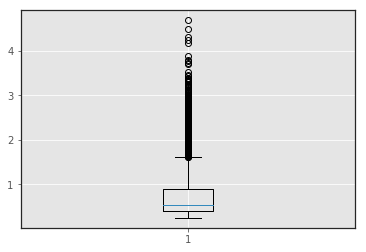

In [16]:
tcga_amps.Segment_Mean.describe()
_ = plt.boxplot(tcga_amps.Segment_Mean)

count    7811.000000
mean       -1.205149
std         1.000346
min        -7.427400
25%        -1.595200
50%        -0.851300
75%        -0.528300
max        -0.250200
Name: Segment_Mean, dtype: float64

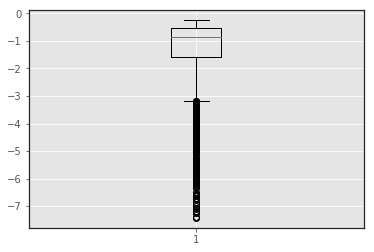

In [17]:
tcga_dels.Segment_Mean.describe()
_ = plt.boxplot(tcga_dels.Segment_Mean)


# 2. Process TCGA cns

In [210]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n tcga_cnv_amps.txt > tcga_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b tcga_cnv_amps.txt.sorted -wa -wb > tcga_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n tcga_cnv_dels.txt > tcga_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b tcga_cnv_dels.txt.sorted -wa -wb > tcga_cnv_dels_bins_1kb.txt


In [212]:
wkdir

'/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'

In [213]:
def calculate_occurence(f):
    df = pd.read_csv(f, sep='\t', header=None)#, nrows=200)
    df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
    occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end'])['patient'].nunique()#.sort_values(ascending=False)
    recur_cnvs = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])

    recur_cnvs.head(2)
    return recur_cnvs

In [6]:
f = f'{wkdir}tcga_cnv_amps_bins_1kb.txt'
# tcga_recur_amps = calculate_occurence(f)

of = f'{f}.patients'
# tcga_recur_amps.to_csv(of, index=False, sep='\t')
tcga_recur_amps = pd.read_csv(of, sep='\t')

In [7]:
tcga_recur_amps.head()
tcga_recur_amps.shape

,bin_chr,bin_start,bin_end,patient
0,1,61001,62000,48
1,1,62001,63000,48
2,1,63001,64000,47
3,1,64001,65000,47
4,1,65001,66000,47


(2898044, 4)

In [9]:
f = f'{wkdir}tcga_cnv_dels_bins_1kb.txt'
# tcga_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
# tcga_recur_dels.to_csv(of, index=False, sep='\t')
tcga_recur_dels = pd.read_csv(of, sep='\t')
tcga_recur_dels[:2]
tcga_recur_dels.shape

,bin_chr,bin_start,bin_end,patient
0,1,61001,62000,26
1,1,62001,63000,27


(2875455, 4)

In [219]:
# tcga_recur_amps = pd.read_csv(of, sep='\t')
# tcga_recur_amps.head()

In [10]:
f11 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/chr_bins.txt'
df11 = pd.read_csv(f11, sep='\t', header=None)
df11.columns = ['bin_chr', 'bin_start', 'bin_end']
df11.set_index(['bin_chr', 'bin_start', 'bin_end'], inplace=True)
# df11['patient'] = 0
df11.head()

Empty DataFrame
Columns: []
Index: [(1, 1, 1000), (1, 1001, 2000), (1, 2001, 3000), (1, 3001, 4000), (1, 4001, 5000)]

In [11]:
def reindex_df(indf, num_patients):
    df = indf.set_index(['bin_chr', 'bin_start', 'bin_end']).reindex(df11.index)
    df.fillna(0, inplace=True)
    df['fraction_patients'] = df.patient/num_patients
    df.drop('patient', inplace=True, axis=1)
    return df

In [12]:
# df_amps.reset_index()['bin_start'].cumsum() # not just accumulateive sum, depending on chr.

In [13]:
def calculate_fractions(df):
    end = 0
    all_positions = []
    all_fractions = []
    for ch, length in enumerate(chr_length):
        ch+=1
        positions = list(end + np.array(df.iloc[df.index.get_level_values('bin_chr') == ch].index.get_level_values('bin_start').tolist()))
        all_positions = all_positions + positions
        fractions = df.iloc[df.index.get_level_values('bin_chr') == ch]['fraction_patients'].tolist()
        all_fractions = all_fractions + fractions
        end+=length
    return (all_positions, all_fractions)




In [14]:
def get_coordinates_fractions(indf, num_patients):
    df = reindex_df(indf, num_patients)
    coordinates, fractions = calculate_fractions(df)
    return (coordinates, fractions)

In [15]:
def plot_fraction(coordinates, fractions, baseline, cnv_type, ax):
    baseline_postions = [baseline] * len(coordinates)
    if cnv_type.lower() == 'amps':
        fractions = baseline + np.array(fractions)
        color = 'red'
    elif cnv_type.lower() == 'dels':
        fractions = baseline - np.array(fractions)
        color = 'blue'
    ax.fill_between(coordinates, 
                    fractions, 
                    baseline_postions, 
                    color=color, 
                    alpha=1)

In [16]:
f2_1 = '/home/szong/projects/resource/chrominfo.txt'
df2_1 = pd.read_csv(f2_1, sep='\t', usecols=['#chrom', 'size'])
df2_1['chr'] = df2_1['#chrom'].apply(lambda x: x.replace('chr', ''))
chr_sizes = df2_1.set_index('chr').drop('#chrom', axis=1)
chr_sizes = chr_sizes.reset_index().replace('X', '23').replace('Y', '24').iloc[:24,].set_index('chr')
chr_sizes.index = chr_sizes.index.astype(int)
chr_sizes = chr_sizes.sort_index()
chr_sizes.head(2)
# initiate occupied label coordinates dict
chr_length = chr_sizes['size']#.astype(str)
y_coords = np.arange(7, .5, -0.5)

,size
chr,
1,249250621
2,243199373


# 2. Process HTMCP copy number

## all 118 patients

,chr,start,end,Segment_Mean,patient
0,1,10001,4190000,0.516688,HTMCP-03-06-02001
1,1,4190001,4289000,0.481328,HTMCP-03-06-02001


count    36671.000000
mean         0.601824
std          0.432422
min          0.250000
25%          0.354646
50%          0.472027
75%          0.695836
max          6.622359
Name: Segment_Mean, dtype: float64

count    53769.000000
mean        -0.959783
std          2.694981
min        -30.045690
25%         -0.756816
50%         -0.547920
75%         -0.370154
max         -0.250002
Name: Segment_Mean, dtype: float64

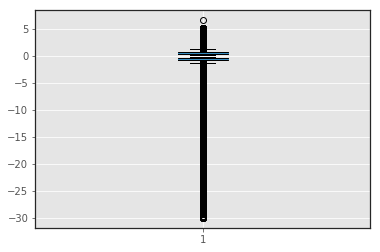

In [244]:
# f3 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
df3 = pd.read_csv(htmcp_file, sep='\t', header=None)
df3.columns = ['patient', 'chr', 'start', 'end', 'Num_Probes', 'Segment_Mean']
df3 = df3[['chr', 'start', 'end','Segment_Mean', 'patient']]
df3.head(2)

htmcp_amps = df3[df3.Segment_Mean >= amp_threshold]
htmcp_dels = df3[df3.Segment_Mean <= del_threshold]

htmcp_amps.to_csv(f'{wkdir}htmcp_cnv_amps.txt', sep='\t', header=None, index=False)
htmcp_dels.to_csv(f'{wkdir}htmcp_cnv_dels.txt', sep='\t', header=None, index=False)

# htmcp_amps.Segment_Mean.describe()
# _ = plt.boxplot(htmcp_amps.Segment_Mean)

# htmcp_dels.Segment_Mean.describe()
# _ = plt.boxplot(htmcp_dels.Segment_Mean)

In [232]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n htmcp_cnv_amps.txt > htmcp_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_cnv_amps.txt.sorted -wa -wb > htmcp_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n htmcp_cnv_dels.txt > htmcp_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_cnv_dels.txt.sorted -wa -wb > htmcp_cnv_dels_bins_1kb.txt


In [233]:
f = f'{wkdir}htmcp_cnv_amps_bins_1kb.txt'
htmcp_recur_amps = calculate_occurence(f)
of = f'{f}.patients'
htmcp_recur_amps.to_csv(of, index=False, sep='\t')

In [234]:
f = f'{wkdir}htmcp_cnv_dels_bins_1kb.txt'
htmcp_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
htmcp_recur_dels.to_csv(of, index=False, sep='\t')

## HIV + patient 73

,chr,start,end,Segment_Mean,patient
0,1,10001,4190000,0.516688,HTMCP-03-06-02001
1,1,4190001,4289000,0.481328,HTMCP-03-06-02001


73

count    19800.000000
mean         0.619098
std          0.478016
min          0.250000
25%          0.357308
50%          0.481406
75%          0.698178
max          6.622359
Name: Segment_Mean, dtype: float64

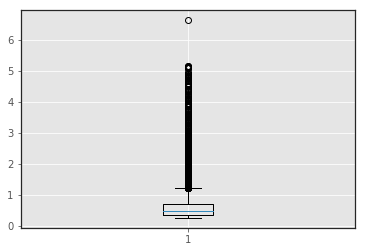

count    35953.000000
mean        -0.920204
std          2.611578
min        -30.045690
25%         -0.746297
50%         -0.520869
75%         -0.361164
max         -0.250002
Name: Segment_Mean, dtype: float64

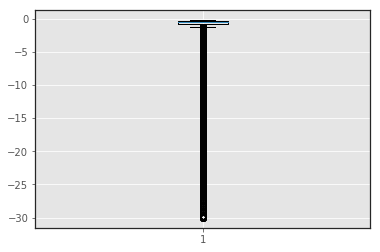

In [26]:
# f3 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
df3 = pd.read_csv(htmcp_hiv_pos_file, sep='\t', header=None)
df3.columns = ['patient', 'chr', 'start', 'end', 'Num_Probes', 'Segment_Mean']
df3 = df3[['chr', 'start', 'end','Segment_Mean', 'patient']]
df3.head(2)
df3.patient.nunique()

htmcp_hiv_pos_amps = df3[df3.Segment_Mean >= amp_threshold]
htmcp_hiv_pos_dels = df3[df3.Segment_Mean <= del_threshold]

htmcp_hiv_pos_amps.to_csv(f'{wkdir}htmcp_hiv_pos_cnv_amps.txt', sep='\t', header=None, index=False)
htmcp_hiv_pos_dels.to_csv(f'{wkdir}htmcp_hiv_pos_cnv_dels.txt', sep='\t', header=None, index=False)

htmcp_hiv_pos_amps.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_pos_amps.Segment_Mean)
plt.show()

htmcp_hiv_pos_dels.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_pos_dels.Segment_Mean)

In [250]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n htmcp_hiv_pos_cnv_amps.txt > htmcp_hiv_pos_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_pos_cnv_amps.txt.sorted -wa -wb > htmcp_hiv_pos_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n htmcp_hiv_pos_cnv_dels.txt > htmcp_hiv_pos_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_pos_cnv_dels.txt.sorted -wa -wb > htmcp_hiv_pos_cnv_dels_bins_1kb.txt


In [27]:
f = f'{wkdir}htmcp_hiv_pos_cnv_amps_bins_1kb.txt'
# htmcp_hiv_pos_recur_amps = calculate_occurence(f)
of = f'{f}.patients'
# htmcp_hiv_pos_recur_amps.to_csv(of, index=False, sep='\t')
htmcp_hiv_pos_recur_amps = pd.read_csv(of, sep='\t')

f = f'{wkdir}htmcp_hiv_pos_cnv_dels_bins_1kb.txt'
# htmcp_hiv_pos_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
# htmcp_hiv_pos_recur_dels.to_csv(of, index=False, sep='\t')
htmcp_hiv_pos_recur_dels = pd.read_csv(of, sep='\t')

# HIV - patients: 45

,chr,start,end,Segment_Mean,patient
0,1,10001,16901000,-0.027289,HTMCP-03-06-02002
1,1,16901001,17205000,-0.103116,HTMCP-03-06-02002


45

count    16871.000000
mean         0.581550
std          0.370838
min          0.250150
25%          0.351575
50%          0.460560
75%          0.694425
max          5.250338
Name: Segment_Mean, dtype: float64

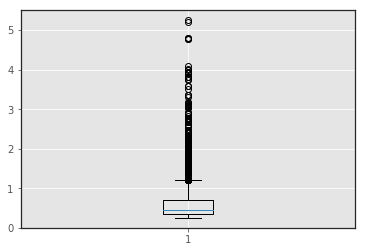

count    17816.000000
mean        -1.039655
std          2.854288
min        -29.981299
25%         -0.775592
50%         -0.585579
75%         -0.393159
max         -0.250023
Name: Segment_Mean, dtype: float64

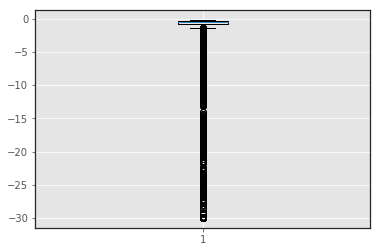

In [252]:
# f3 = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
df3 = pd.read_csv(htmcp_hiv_neg_file, sep='\t', header=None)
df3.columns = ['patient', 'chr', 'start', 'end', 'Num_Probes', 'Segment_Mean']
df3 = df3[['chr', 'start', 'end','Segment_Mean', 'patient']]
df3.head(2)
df3.patient.nunique()

htmcp_hiv_neg_amps = df3[df3.Segment_Mean >= amp_threshold]
htmcp_hiv_neg_dels = df3[df3.Segment_Mean <= del_threshold]

htmcp_hiv_neg_amps.to_csv(f'{wkdir}htmcp_hiv_neg_cnv_amps.txt', sep='\t', header=None, index=False)
htmcp_hiv_neg_dels.to_csv(f'{wkdir}htmcp_hiv_neg_cnv_dels.txt', sep='\t', header=None, index=False)

htmcp_hiv_neg_amps.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_neg_amps.Segment_Mean)
plt.show()

htmcp_hiv_neg_dels.Segment_Mean.describe()
_ = plt.boxplot(htmcp_hiv_neg_dels.Segment_Mean)

In [253]:
%%bash -s $wkdir $bindir
wkdir=$1
bindir=$2
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd $wkdir
sort -k1n -k2n -k3n htmcp_hiv_neg_cnv_amps.txt > htmcp_hiv_neg_cnv_amps.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_neg_cnv_amps.txt.sorted -wa -wb > htmcp_hiv_neg_cnv_amps_bins_1kb.txt
sort -k1n -k2n -k3n htmcp_hiv_neg_cnv_dels.txt > htmcp_hiv_neg_cnv_dels.txt.sorted
$bedtools intersect -a $bindir/chr_bins.txt -b htmcp_hiv_neg_cnv_dels.txt.sorted -wa -wb > htmcp_hiv_neg_cnv_dels_bins_1kb.txt


In [255]:
f = f'{wkdir}htmcp_hiv_neg_cnv_amps_bins_1kb.txt'
htmcp_hiv_neg_recur_amps = calculate_occurence(f)
of = f'{f}.patients'
htmcp_hiv_neg_recur_amps.to_csv(of, index=False, sep='\t')

f = f'{wkdir}htmcp_hiv_neg_cnv_dels_bins_1kb.txt'
htmcp_hiv_neg_recur_dels = calculate_occurence(f)
of = f'{f}.patients'
htmcp_hiv_neg_recur_dels.to_csv(of, index=False, sep='\t')

# 3. plot cnvs

In [17]:
def plot_cnv(ax, baseline, amps, dels, num_patients, vlns):
    ticks = [0, 0.4, 0.8, 1.2, 1.6]
    ticklabels = [0.8, 0.4, 0, 0.4, 0.8]
    ax.set_yticks(ticks, minor=False)
    ax.set_yticklabels(ticklabels, minor=False)
    # ax.set_frame_on(False) # this turn off frame
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    _ = ax.hlines(baseline, 0, vlns[-2], color='black', linewidth=.7)
    for vl in vlns:
        _ = ax.vlines(vl, 0, 1.6, color='gray', linestyle='--', linewidth=.5)
    
#     _ = axhline(baseline + 1, color='gray', linestyle='--', linewidth=.5)
#     _ = axhline(baseline - 1, color='gray', linestyle='--', linewidth=.5)
    coordinates, fractions = get_coordinates_fractions(amps, num_patients)
    plot_fraction(coordinates, fractions, baseline, 'amps', ax)
    coordinates, fractions = get_coordinates_fractions(dels, num_patients)
    plot_fraction(coordinates, fractions, baseline, 'dels', ax)

In [18]:
# plot baseline
start = 0
end = 0
# baseline = 1
vlns = []
mpnts = []
for ch, length in enumerate(chr_length[:-1]):
    ch+=1
    end+=length
    midpoint = (start + end)/2
    mpnts.append(midpoint)
#     _ = ax0.text(midpoint, 1, ch, ha='center')
    if ch %2 == 1:
        vlns.append(start)
        vlns.append(end)
#         _ = fill([start, end, end, start], [0, 0, 11, 11], 'b', alpha=0.1, edgecolor='b')
#         _= ax0.vlines(start, 0, 10, color='gray', linestyle='--', linewidth=.5)
#         _= ax0.vlines(end, 0, 10, color='gray', linestyle='--', linewidth=.5)
    start+=length
#     _ = ax0.text(midpoint, 1, ch, ha='center')


In [19]:
def plot_cytobands(df, ax, clr, y_coord):
    """
    keep in mind sometime notebook does render properly, some lines seem missing, 
    but it will show up when you open the png file. 
    """
    for ix, row in df.iterrows():
        chrom = row.chr
        start = row.start
        end = row.end
        cytoband = row.cytoband
        print(start, end, (end-start), cytoband)
        ax.hlines(y_coord, start, end, color=clr, linewidth=1.5) 

In [20]:
df_bands.shape

NameError: name 'df_bands' is not defined

In [471]:
tcga_bands.dtypes

chr          int64
start        int64
end          int64
cytoband    object
dtype: object

# plot cytoband

In [502]:
tcga_bandf = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/supplemental_Table_7-Amp_Del_Peaks.xlsx'
tcga_band_amps = pd.read_excel(tcga_bandf, sheet_name='All_amps')
tcga_band_amps[:2]
tcga_amps_bands = tcga_band_amps.columns.tolist()
tcga_amps_bands.remove('cytoband')
len(tcga_amps_bands)

,cytoband,11q22.1,3q26.31,20q11.21,8q24.21,3q28,11q13.3,17q25.1,19q13.13,9p24.1,...,6q12,14q11.2,13q34,1p31.3,8p11.21,22q13.31,Xp22.11,11q13.2,2q32.3,19q13.32
0,q value,8.2231e-24,2.0738e-15,6.7744e-10,1.4874e-08,1.3329e-14,1.799e-07,9.4255e-05,2.6629e-05,0.00020757,...,0.10033,0.12486,0.10443,0.17237,0.22602,0.2308,0.23765,0.0005581,0.24581,1.1211e-05
1,residual q value,9.9276e-20,2.4074e-10,6.7744e-10,1.4874e-08,1.3817e-05,4.7655e-05,9.4255e-05,9.475e-05,0.00020757,...,0.10033,0.12486,0.14977,0.17237,0.22602,0.2308,0.23765,0.24448,0.24581,0.41875


29

In [503]:
tcga_bandf = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/supplemental_Table_7-Amp_Del_Peaks.xlsx'
tcga_band_dels = pd.read_excel(tcga_bandf, sheet_name='All_dels')
tcga_band_dels[:2]
tcga_dels_bands = tcga_band_dels.columns.tolist()
tcga_dels_bands.remove('cytoband')
len(tcga_dels_bands)

,cytoband,2q37.1,2q22.1,11q25,4q35.2,19p13.3,10q23.31,13q14.2,1p36.23,17q25.3,...,8p23.3,16q23.1,11p15.1,19p13.12,1p13.2,16p13.3,3p22.1,21q21.1,5q35.3,16q24.3
0,q value,2.1181e-25,6.4977e-17,2.8223e-14,6.1861e-12,5.1501e-12,7.5863e-10,3.9893e-10,4.5785e-05,0.00040073,...,0.16465,0.046327,0.20387,0.01539,0.17674,0.21081,0.23848,0.23482,0.24783,0.0506
1,residual q value,1.2059e-22,7.9934e-15,2.7755e-14,1.2885e-11,2.4884e-11,7.5863e-10,3.3152e-07,5.5176e-05,0.00040073,...,0.15897,0.17674,0.21041,0.21041,0.21194,0.21194,0.23848,0.23848,0.25985,0.27771


38

In [21]:
# plot chromosomes
f3 = '/home/szong/projects/resource/hg19_cytoband_ucsc.txt'
df_cytoband = pd.read_csv(f3, header=None, sep='\t')
df_cytoband.columns = ['chr', 'start', 'end', 'cytoband', 'comments']
df_cytoband['cytoband'] = df_cytoband.chr + df_cytoband['cytoband']
df_cytoband['chr'] = df_cytoband['chr'].replace({'X':'23', 'Y':'24'}).astype(int64)

df_cytoband.head(2)
df_cytoband.tail()
df_cytoband.shape
df_cytoband.dtypes

,chr,start,end,cytoband,comments
0,1,0,2300000,1p36.33,gneg
1,1,2300000,5400000,1p36.32,gpos25


,chr,start,end,cytoband,comments
857,24,15100000,19800000,Yq11.221,gpos50
858,24,19800000,22100000,Yq11.222,gneg
859,24,22100000,26200000,Yq11.223,gpos50
860,24,26200000,28800000,Yq11.23,gneg
861,24,28800000,59373566,Yq12,gvar


(862, 5)

chr          int64
start        int64
end          int64
cytoband    object
comments    object
dtype: object

In [22]:
chromosomes = pd.read_csv(chr_accu_length_f, sep='\t')
chromosomes[:2]
chromosomes.dtypes

,chrom,length,cumulative_length
0,0,0,0
1,1,249250621,249250621


chrom                int64
length               int64
cumulative_length    int64
dtype: object

In [674]:
def arm_coordinates(df_cytoband, chromosomes):
    out = []
    for chrom in df_cytoband.chr.astype(int64).unique():
#         print("xxx", chrom, chromosomes.query('chrom == "{}"'.format(chrom-1)))
        offset =  chromosomes.query('chrom == "{}"'.format(chrom-1))['cumulative_length'].values[0]
#         print('zzz', offset)
        for arm in ['p', 'q']:
            p = df_cytoband[(df_cytoband.chr==chrom)&(df_cytoband.cytoband.str.contains(arm))][['start', 'end']].values.ravel()
            start = p.min()+offset+1
            end = p.max()+offset
            out.append([chrom, arm, start, end])
    return pd.DataFrame(out)

In [675]:
out = arm_coordinates(df_cytoband, chromosomes)

In [685]:
out[4]  = out[[0,1]].apply(lambda x: ''.join(x.astype(str)), axis=1)

In [687]:
out.to_csv(f'{wkdir}chromosome_arm_coordinates.txt', sep='\t', index=False, header=False)

In [23]:
def get_cytoband_coords(df_cytoband):
    # both chromosome size file and cytoband file has consistent chromosome size, checked
    chr_offset = 0 # chromosome offset
    cbands = []
    chromsomes = []
    for chr in np.arange(1,25):
    #     print(chr)
        dfchr = df_cytoband[df_cytoband.chr=='{}'.format(chr)]
        for idx, row in dfchr.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            cytoband = row.cytoband
            comment = row.comments
            center = (start + end)/2 + chr_offset
            width = int(end - start)
    #         print(chr, start, end, cytoband)
            cbands.append([chr, start, end, cytoband])
        chr_offset+=max(dfchr.end)
        print(chr, max(dfchr.end), chr_offset)
        chromsomes.append([chr, max(dfchr.end), chr_offset])


        cytobands = pd.DataFrame(cbands)
        cytobands.columns = ['chr', 'start', 'end', 'cytoband']
        cytobands[:4]
#     pd.DataFrame(chromsomes).to_csv(chr_accu_length_f, index=False, header=False, sep='\t')
    return cytobands

In [24]:
cytobands = get_cytoband_coords(df_cytoband)
# tcga_amp_bands_toplot = cytobands[cytobands.cytoband.isin(tcga_amps_bands)]
# tcga_del_bands_toplot = cytobands[cytobands.cytoband.isin(tcga_dels_bands)]

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [509]:
tcga_amp_bands_toplot.shape
tcga_del_bands_toplot.shape

(29, 4)

(38, 4)

## HIV + cytobands

In [519]:
hivpos_ampf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/amp_genes.conf_99.txt'
hivpos_delf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/del_genes.conf_99.txt'
hivneg_ampf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/amp_genes.conf_99.txt'
hivneg_delf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/del_genes.conf_99.txt'

In [529]:
hivpos_band_amps = pd.read_csv(hivpos_ampf, sep='\t')
hivpos_band_amps[:2]
hivpos_amps_bands = hivpos_band_amps.columns.tolist()
hivpos_amps_bands.remove('cytoband')
len(hivpos_amps_bands)

hivpos_band_dels = pd.read_csv(hivpos_delf, sep='\t')
hivpos_band_dels[:2]
hivpos_dels_bands = hivpos_band_dels.columns.tolist()
hivpos_dels_bands.remove('cytoband')
len(set(hivpos_dels_bands))



,cytoband,5p15.33,11q22.1,15q11.2,3q29,19q13.42,8q24.21,22q13.2,19q11,4p11,...,2p11.2,10q11.22,17q12.1,12q14.2,8p23.1.1,22q11.23,2q21.2,9q34.3,1p32.1,Unnamed: 39
0,q value,7.049e-16,6.0211e-10,9.0942e-10,5.4121e-07,3.3654e-10,9.3637e-06,1.2218e-05,2.5486e-06,5.5824e-06,...,0.1303,0.1303,0.1275,0.16224,0.10042,0.13986,0.21838,0.24714,0.0046579,NaN
1,residual q value,1.1599e-14,6.0211e-10,9.0942e-10,5.4121e-07,7.6393e-07,9.3637e-06,1.2682e-05,1.7323e-05,2.4122e-05,...,0.1303,0.1303,0.1303,0.16224,0.17346,0.17346,0.2452,0.24714,0.40904,NaN


39

,cytoband,3p14.2,8p23.1,14q11.2,5q35.3,19q13.31,15q11.2,1q21.1,1q44,1p36.21,...,17q25.3,5q14.2,1p36.13.1,3q29,4q13.2,12p13.2,13q21.32,11q11,20p12.1.1,Unnamed: 53
0,q value,5.0305e-17,4.8388e-18,8.4541e-17,7.8692e-15,3.0018e-16,2.2995e-12,1.9606e-14,8.8408e-17,8.733e-14,...,0.022708,0.097085,1.3168e-07,0.02853,0.16691,0.17806,0.079098,0.070448,0.0010378,NaN
1,residual q value,5.0305e-17,5.3914e-15,5.3914e-15,7.8692e-15,1.1302e-14,2.2995e-12,2.764e-11,3.3029e-10,3.0489e-09,...,0.090599,0.097085,0.13188,0.14221,0.16701,0.17806,0.20409,0.21543,1,NaN


53

In [525]:
hivneg_band_amps = pd.read_csv(hivneg_ampf, sep='\t')
hivneg_band_amps[:2]
hivneg_amps_bands = hivneg_band_amps.columns.tolist()
hivneg_amps_bands.remove('cytoband')
len(hivneg_amps_bands)

hivneg_band_dels = pd.read_csv(hivneg_delf, sep='\t')
hivneg_band_dels[:2]
hivneg_dels_bands = hivneg_band_dels.columns.tolist()
hivneg_dels_bands.remove('cytoband')
len(hivneg_dels_bands)



,cytoband,5p15.33,14q11.2,19q13.42,3q29,15q11.2,13q11,11q22.2,19q11,1q44,...,15q26.1,10p11.1,2p24.3,8p23.1.1,1q21.3,12q21.1,1p11.2,10q26.3,12q14.2,Unnamed: 28
0,q value,1.3354e-06,6.0142e-05,3.417e-05,2.3008e-05,0.00046882,0.0010876,0.0012687,0.00099777,0.0046513,...,0.050903,0.067496,0.070447,0.011103,0.047194,0.067496,0.14289,0.19065,0.068611,NaN
1,residual q value,1.7524e-06,6.0142e-05,8.6763e-05,0.00034908,0.00069626,0.0010876,0.0012687,0.0013604,0.0058579,...,0.057816,0.067496,0.070447,0.07128,0.077684,0.086665,0.15357,0.19065,0.20017,NaN


28

,cytoband,8p23.1,1q21.1,5q35.3,19q13.31,9p11.2,14q11.2,15q11.1,6p22.1,19p12,...,11q21,13q13.2,17q21.2,4q35.2,13q13.1,4p16.1,7q33,15q11.2,15q14,Unnamed: 45
0,q value,4.2144e-11,4.2144e-11,2.019e-09,1.4513e-09,3.809e-09,1.4513e-09,1.7752e-10,1.8776e-06,1.9475e-05,...,0.090825,0.027355,0.0948,0.10307,0.0067496,0.044067,0.21196,4.2144e-11,0.002349,NaN
1,residual q value,5.7312e-10,1.309e-09,2.019e-09,2.9114e-09,3.809e-09,1.3537e-08,7.6998e-08,1.8776e-06,1.9475e-05,...,0.095384,0.095384,0.095384,0.098725,0.098725,0.12442,0.21205,0.3104,0.63404,NaN


45

In [532]:
hivpos_amp_bands_toplot = cytobands[cytobands.cytoband.isin(hivpos_amps_bands)]
hivpos_del_bands_toplot = cytobands[cytobands.cytoband.isin(hivpos_dels_bands)]
hivpos_amp_bands_toplot.shape
hivpos_del_bands_toplot.shape

(34, 4)

(45, 4)

In [533]:
hivneg_amp_bands_toplot = cytobands[cytobands.cytoband.isin(hivneg_amps_bands)]
hivneg_del_bands_toplot = cytobands[cytobands.cytoband.isin(hivneg_dels_bands)]
hivneg_amp_bands_toplot.shape
hivneg_del_bands_toplot.shape

(26, 4)

(42, 4)

# final plot

## get all files

In [ ]:
# tcga
f = f'{wkdir}tcga_cnv_amps_bins_1kb.txt.patients'
tcga_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}tcga_cnv_dels_bins_1kb.txt.patients'
tcga_recur_dels = pd.read_csv(f, sep='\t')

# hiv pos 
f = f'{wkdir}htmcp_hiv_pos_cnv_amps_bins_1kb.txt.patients'
htmcp_hiv_pos_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}htmcp_hiv_pos_cnv_dels_bins_1kb.txt.patients'
htmcp_hiv_pos_recur_dels = pd.read_csv(f, sep='\t')

# hiv neg
f = f'{wkdir}htmcp_hiv_neg_cnv_amps_bins_1kb.txt.patients'
htmcp_hiv_neg_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}htmcp_hiv_neg_cnv_dels_bins_1kb.txt.patients'
htmcp_hiv_neg_recur_dels = pd.read_csv(f, sep='\t')



In [34]:
# chromosome arm coordinates
f = f'{wkdir}chromosome_arm_coordinates.txt'
chr_arms = pd.read_csv(f, sep='\t')
chr_arms[:2]

# unique arm level alterations
of = f'{wkdir}hivpos_uniqamp_arms.txt'
of = f'{wkdir}hivneg_uniqamp_arms.txt'
of = f'{wkdir}hivpos_uniqdel_arms.txt'
of = f'{wkdir}hivneg_uniqdel_arms.txt'


,chrom,arm,start,end,chr_arm
0,1,p,1,125000000,1p
1,1,q,125000001,249250621,1q


(0.0, 1.0, 0.0, 1.0)

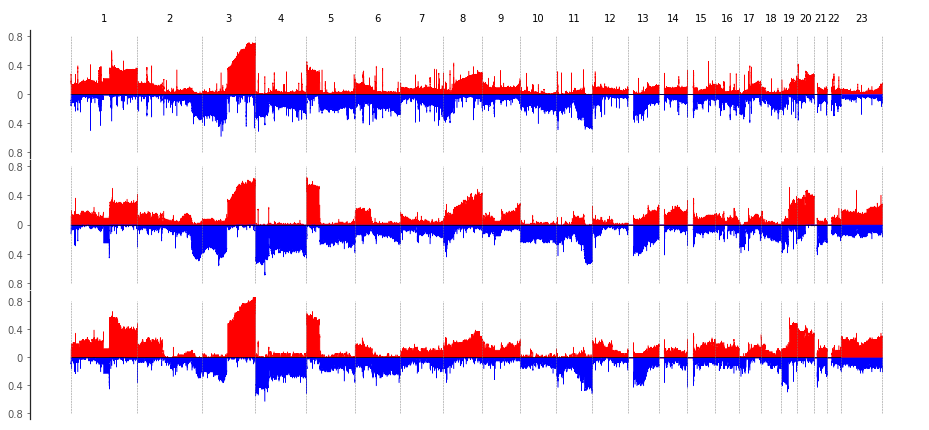

In [29]:
baseline = 0.8
fig = plt.figure(figsize=(16, 10), facecolor='white')
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 6, 6, 6, 6], 
                       hspace=0.02)  # vertical space

# plot chromosome names
ax0 = plt.subplot(gs[0], facecolor='white')
ax0.axis('off')
for vl in vlns:
    _ = ax0.vlines(vl, 0, 1.6, color='white', linestyle='--', linewidth=.5)

# print(vlns, mpnts)
for (ch, mpnt) in enumerate(mpnts):
#     print(int(m), int(ch))
    _ = ax0.text(int(mpnt), 0.5, int(ch)+1, ha='center') 

# plot tcga cnvs
ax1 = plt.subplot(gs[1], facecolor='white')
plot_cnv(ax1, baseline, tcga_recur_amps, tcga_recur_dels, num_tcga_patients, vlns)



# # plot htmcp cnvs 118 patients
# ax2 = plt.subplot(gs[2], facecolor='white')
# plot_cnv(ax2, baseline, htmcp_recur_amps, htmcp_recur_dels, num_htmcp_patients, vlns)


# plot htmcp cnvs hiv+ 73 patients
ax2 = plt.subplot(gs[2], facecolor='white')
plot_cnv(ax2, baseline, htmcp_hiv_pos_recur_amps, htmcp_hiv_pos_recur_dels, num_htmcp_hiv_pos_patients, vlns)


# plot htmcp cnvs hiv+ 45 patients
ax3 = plt.subplot(gs[3], facecolor='white')
plot_cnv(ax3, baseline, htmcp_hiv_neg_recur_amps, htmcp_hiv_neg_recur_dels, num_htmcp_hiv_neg_patients, vlns)

# # plot cn significantly altered cytobands
# ax4 = plt.subplot(gs[4], facecolor='white')
# ax4.axis('off')
# for vl in vlns:
#     _ = ax4.vlines(vl, 0, 1.6, color='gray', linestyle='--', linewidth=.5)
# plot_cytobands(tcga_amp_bands_toplot, ax4, 'red', 1.0)
# plot_cytobands(hivpos_amp_bands_toplot, ax4, 'red', 0.9)
# plot_cytobands(hivpos_amp_bands_toplot, ax4, 'red', 0.8)

# plot_cytobands(tcga_del_bands_toplot, ax4, 'blue', 0.6)
# plot_cytobands(hivpos_del_bands_toplot, ax4, 'blue', 0.5)
# plot_cytobands(hivpos_amp_bands_toplot, ax4, 'blue', 0.4)


# plt.savefig(f'{wkdir}cnvs_publication.png', dpi=300, bbox_inches='tight')

In [36]:
htmcp_hivpos_arm_ampf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/broad_significance_results.txt'
htmcp_hivpos_arm_ampdf = pd.read_csv(htmcp_hivpos_arm_ampf, sep='\t')
htmcp_hivpos_arm_ampdf[:2]

htmcp_hivpos_arm_ampdf = htmcp_hivpos_arm_ampdf[(htmcp_hivpos_arm_ampdf['Amp q-value'] <=0.25)]
#                                                 |(htmcp_hivpos_arm_ampdf['Del q-value'] <=0.25)]


htmcp_hivpos_arm_ampdf[:2]

,Arm,# Genes,Amp frequency,Amp z-score,Amp q-value,Del Frequency,Del z-score,Del q-value
0,1p,2121,0.48,3.16,0.003890,0.17,-1.78,0.998
1,1q,1955,0.59,5.08,0.000004,0.06,-2.92,0.998


,Arm,# Genes,Amp frequency,Amp z-score,Amp q-value,Del Frequency,Del z-score,Del q-value
0,1p,2121,0.48,3.16,0.003890,0.17,-1.78,0.998
1,1q,1955,0.59,5.08,0.000004,0.06,-2.92,0.998


In [37]:
htmcp_hivneg_arm_ampf = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/broad_significance_results.txt'
htmcp_hivneg_arm_ampdf = pd.read_csv(htmcp_hivneg_arm_ampf, sep='\t')
htmcp_hivneg_arm_ampdf[:2]

htmcp_hivneg_arm_ampdf = htmcp_hivneg_arm_ampdf[(htmcp_hivneg_arm_ampdf['Amp q-value'] <=0.25)]
# |(htmcp_hivneg_arm_ampdf['Del q-value'] <=0.25)]


htmcp_hivneg_arm_ampdf[:2]

,Arm,# Genes,Amp frequency,Amp z-score,Amp q-value,Del Frequency,Del z-score,Del q-value
0,1p,2121,0.51,2.90,9.360000e-03,0.31,0.131,0.993
1,1q,1955,0.75,6.58,4.760000e-10,0.08,-1.620,0.993


,Arm,# Genes,Amp frequency,Amp z-score,Amp q-value,Del Frequency,Del z-score,Del q-value
0,1p,2121,0.51,2.90,9.360000e-03,0.31,0.131,0.993
1,1q,1955,0.75,6.58,4.760000e-10,0.08,-1.620,0.993


In [365]:
# _ = axhline(baseline, color='black', linewidth=.7)
# _ = axhline(baseline + 1, color='gray', linestyle='--', linewidth=.5)
# _ = axhline(baseline - 1, color='gray', linestyle='--', linewidth=.5)
# coordinates, fractions = get_coordinates_fractions(tcga_recur_amps, num_tcga_patients)
# plot_fraction(coordinates, fractions, baseline, 'amps', ax)
# coordinates, fractions = get_coordinates_fractions(tcga_recur_dels, num_tcga_patients)
# plot_fraction(coordinates, fractions, baseline, 'dels', ax)

# #plot htmcp
# baseline = 7
# _ = axhline(baseline, color='black', linewidth=.7)
# _ = axhline(baseline + 1, color='gray', linestyle='--', linewidth=.5)
# _ = axhline(baseline - 1, color='gray', linestyle='--', linewidth=.5)
# coordinates, fractions = get_coordinates_fractions(htmcp_recur_amps, num_htmcp_patients)
# plot_fraction(coordinates, fractions, baseline, 'amps', ax)
# coordinates, fractions = get_coordinates_fractions(htmcp_recur_dels, num_htmcp_patients)
# plot_fraction(coordinates, fractions, baseline, 'dels', ax)

# #plot hiv +
# baseline = 5
# _ = axhline(baseline, color='black', linewidth=.7)
# _ = axhline(baseline + 1, color='gray', linestyle='--', linewidth=.5)
# _ = axhline(baseline - 1, color='gray', linestyle='--', linewidth=.5)
# coordinates, fractions = get_coordinates_fractions(htmcp_hiv_pos_recur_amps, num_htmcp_hiv_pos_patients)
# plot_fraction(coordinates, fractions, baseline, 'amps', ax)
# coordinates, fractions = get_coordinates_fractions(htmcp_hiv_pos_recur_dels, num_htmcp_hiv_pos_patients)
# plot_fraction(coordinates, fractions, baseline, 'dels', ax)

# #plot hiv -
# baseline = 3
# _ = axhline(baseline, color='black', linewidth=.7)
# _ = axhline(baseline + 1, color='gray', linestyle='--', linewidth=.5)
# _ = axhline(baseline - 1, color='gray', linestyle='--', linewidth=.5)
# coordinates, fractions = get_coordinates_fractions(htmcp_hiv_neg_recur_amps, num_htmcp_hiv_neg_patients)
# plot_fraction(coordinates, fractions, baseline, 'amps', ax)
# coordinates, fractions = get_coordinates_fractions(htmcp_hiv_neg_recur_dels, num_htmcp_hiv_neg_patients)
# plot_fraction(coordinates, fractions, baseline, 'dels', ax)
plt.show()

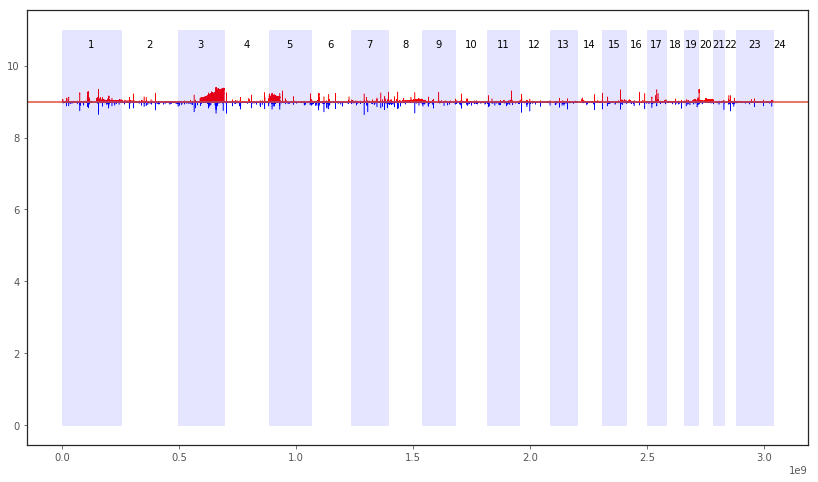

In [167]:
# plot all annoatations
plot_genes(ax, df)
ax.set_xlim(0,sum(chr_length))
ax.set_ylim(0,11)
ax.set_xticklabels('')
ax.set_yticklabels('')
# plt.savefig('{}cnvs_publication.png'.format(wkdir), dpi=300, bbox_inches='tight')
plt.show()

# remove germline cnv based on TCGA filter list

In [49]:
# [szong@szong01 gatk_118_HIV_pos]$ bedtools intersect -a segmentationfile.seg.sorted -b /projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/CNV.hg19.bypos.111213.from.Andrew.Cherniack.txt.sorted -f 0.5 -wa|cut -f 1-3,6|sort -u|wc -l
15941/100222
# [szong@szong01 gatk_118_HIV_pos]$ bedtools intersect -a segmentationfile.seg.sorted -b /projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/CNV.hg19.bypos.111213.from.Andrew.Cherniack.txt.sorted -f 0.25 -wa|cut -f 1-3,6|sort -u|wc -l
20857/100222
# [szong@szong01 gatk_118_HIV_pos]$ bedtools intersect -a segmentationfile.seg.sorted -b /projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/CNV.hg19.bypos.111213.from.Andrew.Cherniack.txt.sorted -f 0.1 -wa|cut -f 1-3,6|sort -u|wc -l
30602/100222
# [szong@szong01 gatk_118_HIV_pos]$ wc -l segmentationfile.seg.sorted
# 0.75 overlap
13572/100222 

# tcga 50% overlap
123924/267855

# tcga 25% overlap
134164/267855

# tcga 10% overlap
154704/267855

# tcga any overlap
240901/267855

# overlap with tcga w/o germline cnv seg file
#overlap 50%
482/59450 
# overlap 25%
1927/59450 

# overlap 10%
7217/59450 

# any overlap
39703/59450

# 75% overlap
149/59450


0.15905689369599488

0.20810800023946838

0.30534214044820496

0.1354193690008182

0.4626533012264098

0.5008829403968565

0.5775662205297643

0.8993709283007597

0.008107653490328007

0.032413793103448274

0.12139613120269134

0.667838519764508

0.0025063078216989066

# below are outdated

hiv status, need to run for hiv pos and neg seprately and then plot together

In [4]:
# tcga cesc snp6 array  copy number segment data
# this is the snp6 copy number pipeline description
tf = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt'
tdf = pd.read_csv(tf, sep='\t')
tdf.head(2)

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean
0,TCGA-2W-A8YY-10A-01D-A37M-01,1,3218610,247813706,129020.0,0.0023
1,TCGA-2W-A8YY-10A-01D-A37M-01,2,484222,197697735,104518.0,0.0041


In [5]:
tdf.Segment_Mean.describe()


count    59450.000000
mean        -0.277859
std          0.909053
min         -7.880800
25%         -0.578700
50%         -0.001300
75%          0.059200
max          6.388700
Name: Segment_Mean, dtype: float64

In [7]:
# tdf[tdf.Segment_Mean == 0.0000]

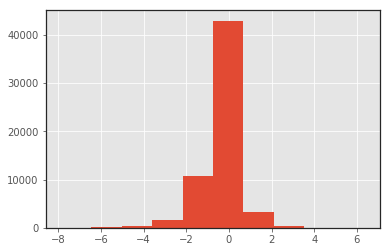

In [8]:
tdf.Segment_Mean.hist()

what is gain and what is loss? it can not be just >0 and <0, there should be a threshold?, Segment_Mean is log2CN-1

In [9]:
tdf.Sample.apply(lambda x: x.split('-')[3]).unique()

array(['10A', '01A', '10B', '01B', '01C', '11A', '06A', '11C'],
      dtype=object)

In [10]:
tdf['tumour_or_normal'] = tdf.Sample.apply(lambda x: x.split('-')[3])

In [11]:
tdf = tdf[~tdf.tumour_or_normal.isin(['10A', '10B', '11A', '11C'])]

In [12]:
tdf.head(2)
tdf.shape

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean,tumour_or_normal
41,TCGA-2W-A8YY-01A-11D-A37M-01,1,3218610,247813706,128923.0,0.0158,01A
42,TCGA-2W-A8YY-01A-11D-A37M-01,2,484222,150727175,78233.0,0.0076,01A


(41253, 7)

In [37]:
tdf.Sample.apply(lambda x: '-'.join(x.split('-')[:3])).nunique() # only two samples with duplicated biopsies

tdf.Sample.nunique()
# all 178 sample in TCGA core set are in this file except 1: TCGA-EA-A3HU-01A

295

297

In [36]:
pd.Series(tdf.Sample.apply(lambda x: '-'.join(x.split('-')[:4])).unique()).to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_variants/cn_patients_297.txt', index=False)

In [16]:
tdf['CN'] = np.power(2, (tdf.Segment_Mean + 1))

In [29]:
tdf.CN.describe()

count    41253.000000
mean         2.029823
std          1.719877
min          0.008485
25%          1.342573
50%          1.977394
75%          2.254176
max        167.579283
Name: CN, dtype: float64

(0, 10)

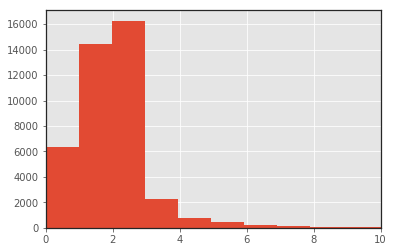

In [28]:
tdf.CN.hist(bins=170)
plt.xlim(0,10)

In [173]:
inf = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/mutation_load_clinic.txt'
clinic = pd.read_csv(inf, sep='\t', index_col='patient')
clinic.head()

,snv_counts,indel_counts,snv_sns_counts,indel_sns_counts,snv_syno_counts,indel_syno_counts,strelka_mutations,strelka_coding_mutations,strelka_syno_mutations,strelka_nsyno_mutations,...,live_birth_pregnancy_count,menopause_status,nadir_cd4_counts,patient_id,pregnancies_count_induced_abortion,pregnancies_count_miscarriage,tobacco_smoking_history_indicator,total_pregnancy_count,tumor_grade,weight_kg_at_diagnosis
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,25732,1242,329,11,102,0,26974,340,102,238,...,5.0,Post (prior bilateral ovariectomy OR >12 mo si...,NaN,2001.0,NaN,1.0,1.0,6.0,G2,44.5
HTMCP-03-06-02002,15964,697,225,2,72,0,16661,227,72,155,...,8.0,Post (prior bilateral ovariectomy OR >12 mo si...,NaN,2002.0,3.0,NaN,1.0,11.0,G3,70.2
HTMCP-03-06-02003,7914,483,89,3,29,0,8397,92,29,63,...,4.0,Pre (<6 months since LMP AND no prior bilatera...,NaN,2003.0,NaN,NaN,1.0,5.0,G2,56.2
HTMCP-03-06-02006,19931,1766,258,16,84,0,21697,274,84,190,...,2.0,Pre (<6 months since LMP AND no prior bilatera...,NaN,2006.0,1.0,NaN,1.0,3.0,G3,61.3
HTMCP-03-06-02007,2928432,29850,20685,50,4469,0,2958282,20735,4469,16266,...,6.0,Post (prior bilateral ovariectomy OR >12 mo si...,NaN,2007.0,NaN,NaN,1.0,6.0,G3,47.1


In [174]:
assert ('HTMCP-03-06-02061' in clinic.index) == False
HIV_pos = clinic.query('HIV_status == "{}"'.format('Positive')).index.tolist()
HIV_neg = clinic.query('HIV_status == "{}"'.format('Negative')).index.tolist()

visualize all cnvs in one plot

In [175]:
# f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/Cervical_124_patients_adjusted/cnv_files_for_acen_removal.txt'
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cleaned_cnv_files.txt'
df1 = pd.read_csv(f1, sep='\t', header=None, comment='#')
df1.columns = ['patient', 'seg_path']
assert df1.shape[0] == 124
df1.head(2)

,patient,seg_path
0,HTMCP-03-06-02001,/projects/trans_scratch/validations/workspace/...
1,HTMCP-03-06-02002,/projects/trans_scratch/validations/workspace/...


In [176]:
df1.shape

(124, 2)

In [177]:
df1 = df1.loc[df1.patient.isin(HIV_pos)]
# df1 = df1.loc[df1.patient.isin(HIV_neg)]

In [178]:
df2 = pd.DataFrame()
for idx, row in df1.iterrows():
    pat = row['patient']
    seg_file = row['seg_path']
#     print(pat, seg_file)
    # cnv_files, some rows have 10 columns instead of 9, problems from the APLcnv pipeline
    cnv = pd.read_csv(seg_file, sep='\t',  error_bad_lines=False, warn_bad_lines=True)
    cnv.columns = ['chr', 'start', 'end', 'cn']
    cnv = cnv[cnv.cn != 2]
    cnv['patient'] = pat
    if df2.empty:
        df2 = cnv
    else: df2 = pd.concat([df2,cnv])

In [179]:
df2.tail(2)

,chr,start,end,cn,patient
892,23,80846333,155112387,3,HTMCP-03-06-02447
28,20,14917359,15022654,1,HTMCP-03-06-02448


In [180]:
df2.shape

(26573, 5)

In [181]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned.txt'
df2[df2.cn >2].to_csv(of, index=False, header=None, sep='\t')

In [182]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned.txt'
df2[df2.cn <2].to_csv(of, index=False, header=None, sep='\t')

In [183]:
%%bash
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/
sort -k1n -k2n -k3n amps_cleaned.txt > amps_cleaned.txt.sorted
sort -k1n -k2n -k3n dels_cleaned.txt > dels_cleaned.txt.sorted
$bedtools intersect -a chr_bins.txt -b dels_cleaned.txt.sorted -wa -wb > dels_cleaned_bins_1kb.txt
$bedtools intersect -a chr_bins.txt -b amps_cleaned.txt.sorted -wa -wb > amps_cleaned_bins_1kb.txt

In [61]:
patients = df2.patient.value_counts().index.tolist()

In [184]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned_bins_1kb_patients.txt'
recur_amps.to_csv(f, index=False, sep='\t')
# recur_amps = pd.read_csv(f, sep='\t')

In [63]:
recur_amps.head(2)

,bin_chr,bin_start,bin_end,patient
0,1,38001,39000,1
1,1,39001,40000,2


In [110]:
f11 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/chr_bins.txt'
df11 = pd.read_csv(f11, sep='\t', header=None)
df11.columns = ['bin_chr', 'bin_start', 'bin_end']
df11.set_index(['bin_chr', 'bin_start', 'bin_end'], inplace=True)
# df11['patient'] = 0
df11.head()

Empty DataFrame
Columns: []
Index: [(1, 1, 1000), (1, 1001, 2000), (1, 2001, 3000), (1, 3001, 4000), (1, 4001, 5000)]

In [106]:
def reindex_df(indf):
    df = indf.set_index(['bin_chr', 'bin_start', 'bin_end']).reindex(df11.index)
    df.fillna(0, inplace=True)
    df['fraction_patients'] = df.patient/ len(HIV_pos)
    df.drop('patient', inplace=True, axis=1)
    return df

In [66]:
# df_amps.reset_index()['bin_start'].cumsum() # not just accumulateive sum, depending on chr.

In [67]:
def calculate_fractions(df):
    end = 0
    all_positions = []
    all_fractions = []
    for ch, length in enumerate(chr_length):
        ch+=1
        positions = list(end + np.array(df.iloc[df.index.get_level_values('bin_chr') == ch].index.get_level_values('bin_start').tolist()))
        all_positions = all_positions + positions
        fractions = df.iloc[df.index.get_level_values('bin_chr') == ch]['fraction_patients'].tolist()
        all_fractions = all_fractions + fractions
        end+=length
    return (all_positions, all_fractions)




In [185]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
recur_dels = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned_bins_1kb_patients.txt'
recur_dels.to_csv(f, index=False, sep='\t')
# recur_dels = pd.read_csv(f, sep='\t')

In [186]:
recur_dels.head(2)

,bin_chr,bin_start,bin_end,patient
0,1,46001,47000,1
1,1,47001,48000,2


In [70]:
hiv_pos_recur_dels = recur_dels
hiv_pos_recur_amps = recur_amps
# hiv_neg_recur_dels = recur_dels
# hiv_neg_recur_amps = recur_amps

In [24]:
# 2 patient has no cnv? 2261 and 2262 have no cnvs
len(patients)
set(HIV_neg) - set(patients)

set()

In [95]:
f2_1 = '/home/szong/projects/resource/chrominfo.txt'
df2_1 = pd.read_csv(f2_1, sep='\t', usecols=['#chrom', 'size'])
df2_1['chr'] = df2_1['#chrom'].apply(lambda x: x.replace('chr', ''))
chr_sizes = df2_1.set_index('chr').drop('#chrom', axis=1)
chr_sizes = chr_sizes.reset_index().replace('X', '23').replace('Y', '24').iloc[:24,].set_index('chr')
chr_sizes.index = chr_sizes.index.astype(int)
chr_sizes = chr_sizes.sort_index()
chr_sizes.head(2)

,size
chr,
1,249250621
2,243199373


In [26]:
chr_sizes.tail()

,size
chr,
20,63025520
21,48129895
22,51304566
23,155270560
24,59373566


In [27]:
chr_sizes.index.unique()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', name='chr')

In [43]:
hiv_neg_recur_amps = recur_amps
hiv_neg_recur_dels = recur_dels

In [28]:
# hiv_pos
# for amps
# df_amps = reindex_df(hiv_pos_recur_amps)
# df_amps = reindex_df(hiv_neg_recur_amps)
# amp_positions, amp_fractions = calculate_fractions(df_amps)

NameError: name 'hiv_pos_recur_amps' is not defined

In [96]:
def plot_fraction(coordinates, fractions, baseline, cnv_type, ax):
    baseline_postions = [baseline] * len(coordinates)
    if cnv_type.lower() == 'amps':
        fractions = baseline + np.array(fractions)
        color = 'red'
    elif cnv_type.lower() == 'dels':
        fractions = baseline - np.array(fractions)
        color = 'blue'
    ax.fill_between(coordinates, 
                    fractions, 
                    baseline_postions, 
                    color=color, 
                    alpha=1)

In [97]:
def get_coordinates_fractions(indf):
    df = reindex_df(indf)
    coordinates, fractions = calculate_fractions(df)
    return (coordinates, fractions)

In [32]:

def get_cnv_oncogenes(gistic_f):
    gistic_df = pd.read_csv(gistic_f, sep='\t')
    gistic_df['oncogene'] = gistic_df.oncogenes.apply(lambda x: x.split(')')[1])
    gistic_df['peak_center'] = gistic_df['wide peak boundaries'].apply(lambda x: int(np.array(x.split('-')).astype(int).mean()))
    gistic_df.drop('oncogenes', axis=1, inplace=True)
    gistic_df = gistic_df[gistic_df.oncogene != '']
    return gistic_df

In [34]:
def gene_coordinate(df):
    end = 0
    all_coordinates = []
    all_genes = []
    for ch, length in enumerate(chr_length):
        ch+=1
        coordinates = list(end + np.array(df.loc[df.chr == ch]['peak_center'].tolist()))
        all_coordinates = all_coordinates + coordinates
        genes = df.loc[df.chr == ch]['oncogene'].tolist()
        all_genes = all_genes + genes
        end+=length
    return (all_coordinates, all_genes)

In [35]:
def get_gene_coords(gistic_f):
#     gistic_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'
    gistic_df = get_cnv_oncogenes(gistic_f)
    coordinates, genes = gene_coordinate(gistic_df)
    return coordinates, genes

In [146]:
def arrange_genes(genes, coordinates, anno_baseline, 
               anno_color, anno_ecolor, arrow_color, 
               ycoords_dict, df):
#     previous_coordinate = 0
#     y_coords = np.arange(6, .5, -0.5)
#     shorter_genes = []
#     for gene in genes:
#         # only displace 2 genes in a label
#         splits = gene.split(',')
#         if len(splits) >2:
#                gene = ','.join(splits[:2])                
#         shorter_genes.append(gene)
#     genes = shorter_genes
    gene_coords = []
    for gene, x_coord in zip(genes, coordinates):
        short_gene = gene
        splits = gene.split(',')
        if len(splits) >2:
            short_gene = ','.join(splits[:2])  
          
        for y_coord in y_coords:
            if all([abs(j-x_coord) >4e8 for j in ycoords_dict[y_coord]]):
                gene_coords.append((short_gene, x_coord, y_coord, gene))
                coords_list = ycoords_dict[y_coord]
                coords_list.append(x_coord)
                ycoords_dict[y_coord] = coords_list
                break #found location to place the label
    dftmp = pd.DataFrame(gene_coords, columns=['gene', 'x', 'y', 'all_oncogenes'])
    dftmp['anno_color'] = anno_color
    dftmp['anno_ecolor'] = anno_ecolor
    dftmp['arrow_color'] = arrow_color
    df = pd.concat([df, dftmp])
    return (ycoords_dict, df) #coordinates for gene lable

In [162]:
def plot_genes(ax, df):
    df = df.sort_values(['y', 'x'], ascending=True)
    for ix, row in df.iterrows():  
        gene = row.gene
        x = row.x
        y = row.y
        anno_color = row.anno_color
        anno_ecolor = row.anno_ecolor
        arrow_color = row.arrow_color
        fill_color = row.fill_color
        ax.annotate('{}'.format(gene),
                    xy=(x,10), 
                    xytext=(x, y), fontsize=10,
                    ha='center', va='bottom', color=anno_color,
                    textcoords='data', xycoords="data", 
                    bbox=dict(boxstyle='round', 
                              fc=fill_color, 
                              edgecolor=anno_ecolor,
                              alpha=1, pad=.4),
                    arrowprops=dict(arrowstyle='-', 
                                    color=anno_color,
                                    shrinkB=0, 
                                    connectionstyle='arc3,rad=0.0' 
                                  ))


In [147]:
# initiate occupied label coordinates dict
chr_length = chr_sizes['size']#.astype(str)
y_coords = np.arange(7, .5, -0.5)
ycoords_dict = {}
for i in y_coords:
    ycoords_dict[i] = []
    
# initiate label coordinates df
df = pd.DataFrame(columns=['gene', 'x', 'y', 'all_oncogenes', 'anno_color', 'anno_ecolor', 'arrow_color'])
fdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'

gistic_f = '{}124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# hiv_pos amps
anno_baseline = 6
anno_color = 'red'
anno_ecolor = 'red'
arrow_color = 'red'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)
# print(df)
gistic_f = '{}124_patient_adj_hiv_pos/del_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# hiv_pos dels

anno_color = 'blue'
anno_ecolor = 'red'
arrow_color = 'blue'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)
# print(df)

# plot hiv_neg genes
gistic_f = '{}124_patient_adj_hiv_neg/amp_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# amps

anno_color = 'red'
anno_ecolor = 'blue'
arrow_color = 'red'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)

gistic_f = '{}124_patient_adj_hiv_neg/del_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# del

anno_color = 'blue'
anno_ecolor = 'blue'
arrow_color = 'blue'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)

In [148]:
df['fill_color'] = 'lightgray'

In [170]:
# df

In [168]:
f = '{}genes_to_highlight.txt'.format(wkdir)
# df.to_csv(f, sep='\t', index=False)
df = pd.read_csv(f, sep='\t')
df.head(2)

,gene,x,y,all_oncogenes,anno_color,anno_ecolor,arrow_color,fill_color
0,(79)AKT1,2304079939,1.5,"AKT1,BRF1,MIR203",blue,blue,blue,lightgray
1,"(115)RB1,TLL",2127705678,2.0,"ARL11,DLEU1,MIR15A,RB1,TTL,DLEU2,KCNRG,LHFP,MI...",blue,blue,blue,lightgray


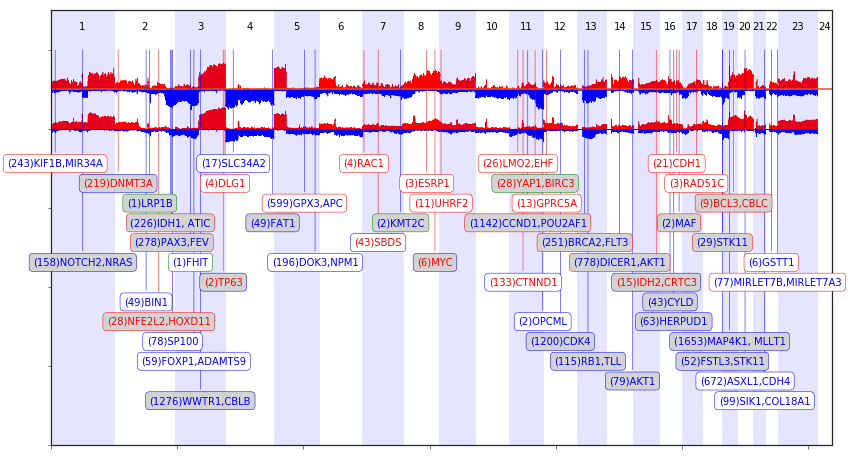

In [171]:

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, facecolor='white')

# plot baseline
start = 0
end = 0
baseline = 9
for ch, length in enumerate(chr_length):
    ch+=1
    end+=length
    midpoint = (start + end)/2
    ax.text(midpoint, 10.5, ch, ha='center')
    if ch %2 == 1:
        fill([start, end, end, start], [0, 0, 11, 11], 'b', alpha=0.1, edgecolor='b')
    start+=length
axhline(baseline)

# area plot example fill between 2 lines
# hiv_pos
baseline = 9
coordinates, fractions = get_coordinates_fractions(hiv_pos_recur_amps)
plot_fraction(coordinates, fractions, baseline, 'amps', ax)
coordinates, fractions = get_coordinates_fractions(hiv_pos_recur_dels)
plot_fraction(coordinates, fractions, baseline, 'dels', ax)

#plot hiv_neg
baseline = 8
coordinates, fractions = get_coordinates_fractions(hiv_neg_recur_amps)
plot_fraction(coordinates, fractions, baseline, 'amps', ax)
coordinates, fractions = get_coordinates_fractions(hiv_neg_recur_dels)
plot_fraction(coordinates, fractions, baseline, 'dels', ax)






# plot all annoatations
plot_genes(ax, df)
ax.set_xlim(0,sum(chr_length))
ax.set_ylim(0,11)
ax.set_xticklabels('')
ax.set_yticklabels('')
# plt.savefig('{}cnvs_publication.png'.format(wkdir), dpi=300, bbox_inches='tight')
plt.show()

# look at expression at chromosome 20

In [192]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/123_patients/12_hiv_pos_patient_with_CELF2_intronic_mutaions.txt'
df44 = pd.read_csv(f, sep=' ', header=None, usecols=[6])
CELF2_patients = df44[6].tolist()

In [241]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/expression.txt'
df45 = pd.read_csv(f2, sep='\t')
df45['genes'] = df45.genes.apply(lambda x: x.split('_')[1])
df45.set_index('genes',inplace=True)
df45

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,HTMCP-03-06-02448
genes,,,,,,,,,,,,,,,,,,,,,
BMP2,24.2485,0.5206,22.7987,16.7144,3.3167,0.9090,5.6723,0.2779,11.9332,11.7344,...,2.4231,15.9290,7.3584,7.5151,22.5350,7.6255,1.6486,15.3510,6.6484,23.3014
NRSN2,8.7759,12.1225,13.0852,15.2838,26.1307,10.5814,13.6064,18.5685,15.1423,17.0035,...,10.6567,11.1115,19.5867,15.0157,11.1103,4.5144,37.4468,38.9413,15.7422,18.2746
RASSF2,0.9829,1.6913,2.6299,2.2896,3.8333,5.3300,1.7596,2.4763,2.8904,3.5951,...,0.6380,0.2974,1.8222,1.7395,0.6566,1.7666,4.7340,2.5992,3.4487,4.7909
CELF2,1.0604,2.0148,1.7215,1.1998,4.8031,3.5291,1.4222,1.5524,2.1163,1.6890,...,0.7011,0.1661,2.6070,0.7677,0.3114,1.4427,17.3580,1.2862,1.3097,2.2684
LEF1,2.3424,3.3140,1.1988,2.3581,24.0241,4.7774,1.8252,1.3020,2.9927,0.6506,...,0.4918,0.2495,3.0928,1.2006,0.3725,1.0076,4.0649,1.1239,1.6038,1.9845
POTEG,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0007,0.0000,0.0000,...,0.0000,0.0012,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AQP7,0.0089,0.0068,0.0684,0.0527,0.0166,0.1316,0.0066,0.0133,0.0141,0.6473,...,0.0663,2.7351,0.5844,0.0248,0.0862,0.7812,1.4339,0.0810,0.0551,0.5056


In [245]:
f3 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/BMP2.txt'
bmp2_cnv = pd.read_csv(f3, sep='\t', header=None, usecols=[0,6])
bmp2_cnv.columns = ['pat', 'cnv']
bmp2_cnv.head(2)

,pat,cnv
0,HTMCP-03-06-02001,2
1,HTMCP-03-06-02002,2


In [247]:
df_bmps = pd.DataFrame(df45.loc["BMP2",]).reset_index()

In [251]:
df47 = pd.merge(bmp2_cnv, df_bmps, left_on='pat', right_on='index')[['pat', 'cnv', 'BMP2']]

In [232]:
df46 = pd.DataFrame(df45.loc["LEF1",]).reset_index()

In [233]:
df46.head(2)

,index,LEF1
0,HTMCP-03-06-02001,2.3424
1,HTMCP-03-06-02002,3.3140


In [234]:
df46['celf2'] = df46['index'].apply(lambda x: 'mut' if x in CELF2_patients else 'wt')

In [235]:
df46.head(2)

,index,LEF1,celf2
0,HTMCP-03-06-02001,2.3424,wt
1,HTMCP-03-06-02002,3.3140,wt


In [198]:
CELF2_muts = df45[CELF2_patients]
CELF2_muts

,HTMCP-03-06-02239,HTMCP-03-06-02216,HTMCP-03-06-02437,HTMCP-03-06-02144,HTMCP-03-06-02202,HTMCP-03-06-02414,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02103,HTMCP-03-06-02103,HTMCP-03-06-02447,HTMCP-03-06-02238,HTMCP-03-06-02071,HTMCP-03-06-02071,HTMCP-03-06-02071,HTMCP-03-06-02071
genes,,,,,,,,,,,,,,,,
BMP2,9.8771,10.7918,7.6255,0.3128,12.6240,15.9600,1.6486,15.3510,21.4400,21.4400,6.6484,7.7629,13.6245,13.6245,13.6245,13.6245
NRSN2,9.0386,14.5508,4.5144,17.5379,19.2714,30.5230,37.4468,38.9413,25.6907,25.6907,15.7422,8.6737,11.6981,11.6981,11.6981,11.6981
RASSF2,0.8492,0.5651,1.7666,4.0812,7.3412,1.6530,4.7340,2.5992,2.8545,2.8545,3.4487,3.4134,2.8528,2.8528,2.8528,2.8528
CELF2,1.3896,0.2450,1.4427,1.6190,3.1406,3.1747,17.3580,1.2862,1.0741,1.0741,1.3097,2.2163,1.0169,1.0169,1.0169,1.0169
LEF1,0.9201,0.7904,1.0076,2.6970,1.6692,12.9375,4.0649,1.1239,1.2212,1.2212,1.6038,1.6132,1.3526,1.3526,1.3526,1.3526
POTEG,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AQP7,0.0038,0.0450,0.7812,0.0041,0.0576,0.2743,1.4339,0.0810,0.0196,0.0196,0.0551,0.6525,0.0000,0.0000,0.0000,0.0000


In [203]:
CELF2_wt = df45[[i for i in df45.columns.tolist() if i not in  CELF2_patients]]

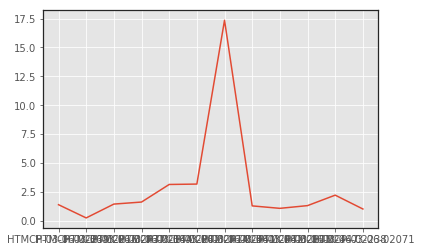

In [204]:
plt.plot(CELF2_muts.loc["CELF2",])

In [215]:
muts = CELF2_muts.loc["CELF2",].values
wts = CELF2_wt.loc["CELF2",].values

In [211]:
muts

array([ 1.3896,  0.245 ,  1.4427,  1.619 ,  3.1406,  3.1747, 17.358 ,
        1.2862,  1.0741,  1.0741,  1.3097,  2.2163,  1.0169,  1.0169,
        1.0169,  1.0169])

In [230]:
df46.head()

,index,CELF2,celf2
0,HTMCP-03-06-02001,1.0604,wt
1,HTMCP-03-06-02002,2.0148,wt
2,HTMCP-03-06-02003,1.7215,wt
3,HTMCP-03-06-02006,1.1998,wt
4,HTMCP-03-06-02007,4.8031,wt


In [252]:
df47.head()

,pat,cnv,BMP2
0,HTMCP-03-06-02001,2,24.2485
1,HTMCP-03-06-02002,2,0.5206
2,HTMCP-03-06-02003,3,22.7987
3,HTMCP-03-06-02006,2,16.7144
4,HTMCP-03-06-02007,2,3.3167


0.08874342839133187


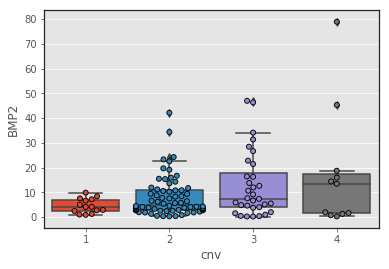

In [263]:
fig = plt.figure()
ax = fig.add_subplot(111)
group_col = 'cnv'
value_col = 'BMP2'
sns.swarmplot(x=group_col, y=value_col, data=df47, edgecolor="black", linewidth=.9, facecolor='blue')
sns.boxplot(x=group_col, y=value_col, data=df47, saturation=1, ax=ax)
g1 = df47.query('{0}=="{1}"'.format(group_col, 1))[value_col]
g2 = df47.query('{0}=="{1}"'.format(group_col, 2))[value_col]
sts, p = ss.mannwhitneyu(g1, g2, use_continuity=True, alternative=None)
print(p)
# sns.swarmplot([2]*len(wts), wts, edgecolor="black", linewidth=.9, facecolor="red")

In [262]:
df47.query('{0}=="{1}"'.format(group_col, 1))

,pat,cnv,BMP2
5,HTMCP-03-06-02008,1,0.9090
16,HTMCP-03-06-02054,1,4.1518
26,HTMCP-03-06-02076,1,2.9091
35,HTMCP-03-06-02139,1,1.0261
43,HTMCP-03-06-02147,1,4.0946
61,HTMCP-03-06-02151,1,2.4556
66,HTMCP-03-06-02213,1,2.7366
71,HTMCP-03-06-02204,1,7.5640
76,HTMCP-03-06-02235,1,1.2797
78,HTMCP-03-06-02239,1,9.8771


In [574]:

tms = 2
def fun(tms):
    w_chgs = np.array([[1,1,1]])
    w = np.array([[1,2,3]])
#     print(w_chgs, w)

    for e in range(tms):
        w += 1
        print('appending', w, type(w))
        w_chgs = np.concatenate((w_chgs, w))
        print(w_chgs)
    return (w, w_chgs)
    
w, w_chgs = fun(tms)
w_chgs

appending [[2 3 4]] <class 'numpy.ndarray'>
[[1 1 1]
 [2 3 4]]
appending [[3 4 5]] <class 'numpy.ndarray'>
[[1 1 1]
 [2 3 4]
 [3 4 5]]


array([[1, 1, 1],
       [2, 3, 4],
       [3, 4, 5]])

In [558]:
a = np.array([[1, 2, 3]])

b = np.array([[9, 8, 7]])

np.concatenate((a, b))

array([[1, 2, 3],
       [9, 8, 7]])

In [13]:
np.argmax?